<a href="https://colab.research.google.com/github/Offliners/writeup/blob/main/HW6/homework6-6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 6 - Generative Adversarial Network**

This is the example code of homework 6 of the machine learning course by Prof. Hung-yi Lee.


In this homework, you are required to build a generative adversarial  network for anime face generation.


## Set up the environment


### Packages Installation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!nvidia-smi

Tue May 11 18:06:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# You may replace the workspace directory if you want.
workspace_dir = './drive/MyDrive/HW6'

# Training progress bar
!pip install -q qqdm
!pip install stylegan2_pytorch

     |████████████████████████████████| 276kB 12.5MB/s 
     |████████████████████████████████| 163kB 36.2MB/s 
     |████████████████████████████████| 92kB 12.2MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 61kB 10.4MB/s 
     |████████████████████████████████| 296kB 50.4MB/s 
     |████████████████████████████████| 163kB 46.4MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
     |████████████████████████████████| 153kB 46.3MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=b2717e0a63055e02cec38928e98e458ddadc2c55854180804a2bb30a1a06a586
  Stored in directory: /root/.cache/pip/wheels/af/19/30/1ea0cad502dcb4e66ed5a690279628c827aea38bbbab75d5ed
  Created wheel for vector-quantize-pytorch: filename=vector_quantize_pytorch-0.1.0-cp37-none-any.whl size=2576 sha256=a442b607d24ae3

### Download the dataset
**Please use the link according to the last digit of your student ID first!**

If all download links fail, please follow [here](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e).

* To open the file using your browser, use the link below (replace the id first!):
https://drive.google.com/file/d/REPLACE_WITH_ID
* e.g. https://drive.google.com/file/d/1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p

In [4]:
!gdown --id 1XpV2G-vOpCH72NU0aWRDToJQf6HbQeBX --output "./crypko_data.zip"
# Other download links
#   Please uncomment the line according to the last digit of your student ID first

# 0
# !gdown --id 131zPaVoi-U--XThvzgRfaxrumc3YSBd3 --output "{workspace_dir}/crypko_data.zip"

# 1
# !gdown --id 1kCuIj1Pf3T2O94H9bUBxjPBKb---WOmH --output "{workspace_dir}/crypko_data.zip"

# 2
# !gdown --id 1boEoiiqBJwoHVvjmI0xgoutE9G0Rv8CD --output "{workspace_dir}/crypko_data.zip"

# 3
# !gdown --id 1Ic0mktAQQvnNAnswrPHsg-u2OWGBXTWF --output "{workspace_dir}/crypko_data.zip"

# 4
# !gdown --id 1PFcc25r9tLE7OyQ-CDadtysNdWizk6Yg --output "{workspace_dir}/crypko_data.zip"

# 5
# !gdown --id 1wgkrYkTrhwDSMdWa5NwpXeE4-7JaUuX2 --output "{workspace_dir}/crypko_data.zip"

# 6
# !gdown --id 19gwNYWi9gN9xVL86jC3v8qqNtrXyq5Bf --output "{workspace_dir}/crypko_data.zip"

# 7 
# !gdown --id 1-KPZB6frRSRLRAtQfafKCVA7em0_NrJG --output "{workspace_dir}/crypko_data.zip"

# 8
# !gdown --id 1rNBfmn0YBzXuG5ub7CXbsGwduZqEs8hx --output "{workspace_dir}/crypko_data.zip"

# 9
# !gdown --id 113NEISX-2j6rBd1yyBx0c3_9nPIzSNz- --output "{workspace_dir}/crypko_data.zip"


Downloading...
From: https://drive.google.com/uc?id=1XpV2G-vOpCH72NU0aWRDToJQf6HbQeBX
To: /content/crypko_data.zip
452MB [00:06, 69.1MB/s]


###Unzip the downloaded file.
The unzipped tree structure is like 
```
faces/
├── 1.jpg
├── 2.jpg
├── 3.jpg
...
```

In [5]:
!unzip -q "./crypko_data.zip" -d "./"

## Random seed
Set the random seed to a certain value for reproducibility.

In [6]:
import random

import torch
import numpy as np


def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(0)

## Import Packages
First, we need to import packages that will be used later.

Like hw3, we highly rely on **torchvision**, a library of PyTorch.

In [7]:
import os
import glob

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm

# For SNGAN
from torch.nn.utils import spectral_norm

## Dataset
1. Resize the images to (64, 64)
1. Linearly map the values from [0, 1] to  [-1, 1].

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.


In [8]:
class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        # 1. Load the image
        img = torchvision.io.read_image(fname)
        # 2. Resize and normalize the images using torchvision.
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples


def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    # 1. Resize the image to (64, 64)
    # 2. Linearly map [0, 1] to [-1, 1]
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

### Show some images
Note that the values are in the range of [-1, 1], we should shift them to the valid range, [0, 1], to display correctly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


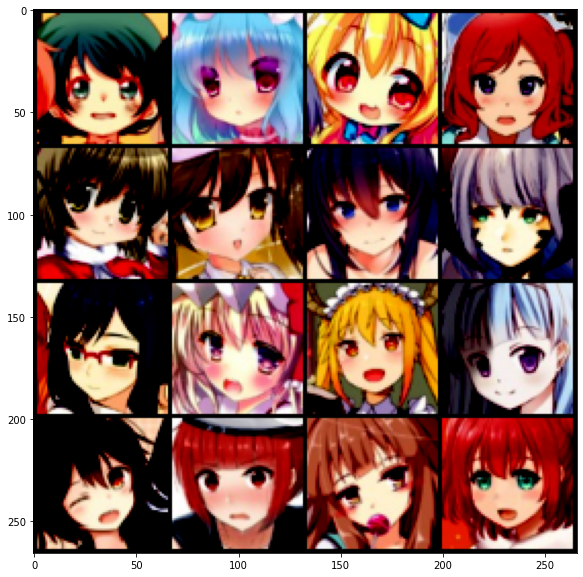

In [9]:
dataset = get_dataset(os.path.join('.', 'faces'))

images = [dataset[i] for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

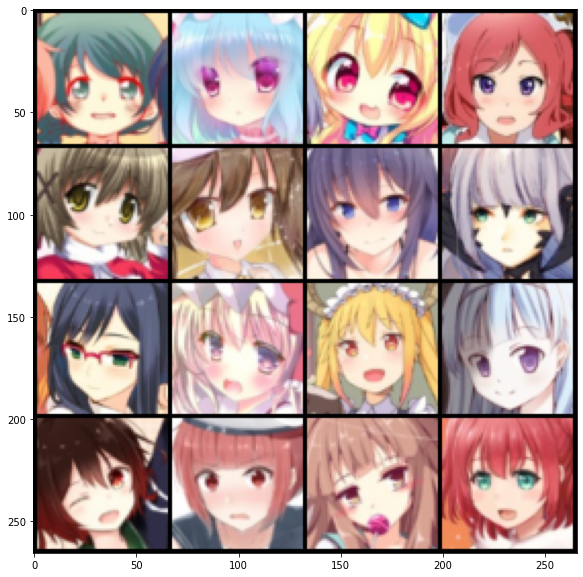

In [10]:
images = [(dataset[i]+1)/2 for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Model
Here, we use a simple CNN-based model structure. Feel free to modify your own model structure.

Note that the `N` of the input/output shape stands for the batch size.

## Training

In [11]:
!stylegan2_pytorch --data faces --results_dir ./drive/MyDrive/HW6/stylegan --models_dir ./drive/MyDrive/HW6/stylegan --num-train-steps 100000 --image-size 64

continuing from previous epoch - 65
loading from version 1.8.1
default<faces>:  65% 65000/100000 [00:00<?, ?it/s]G: 0.37 | D: 1.52 | GP: 0.29
default<faces>:  65% 65045/100000 [00:43<9:52:36,  1.02s/it] G: 0.56 | D: 1.27 | GP: 2.11 | PL: 0.67
default<faces>:  65% 65093/100000 [01:26<9:00:47,  1.08it/s]G: -0.13 | D: 1.60 | GP: 1.74 | PL: 0.68
default<faces>:  65% 65141/100000 [02:09<8:42:35,  1.11it/s]G: 0.44 | D: 1.62 | GP: 0.48 | PL: 0.68
default<faces>:  65% 65189/100000 [02:52<8:42:51,  1.11it/s]G: 0.29 | D: 1.29 | GP: 0.18 | PL: 0.68
default<faces>:  65% 65249/100000 [03:46<8:42:05,  1.11it/s]G: 1.15 | D: 1.36 | GP: 0.24 | PL: 0.68
default<faces>:  65% 65297/100000 [04:28<8:37:11,  1.12it/s]G: 0.22 | D: 1.61 | GP: 0.52 | PL: 0.68
default<faces>:  65% 65345/100000 [05:12<8:40:02,  1.11it/s]G: 1.40 | D: 1.06 | GP: 0.37 | PL: 0.68
default<faces>:  65% 65393/100000 [05:54<8:34:33,  1.12it/s]G: 0.49 | D: 1.32 | GP: 0.17 | PL: 0.68
default<faces>:  65% 65441/100000 [06:37<8:38:29,  1.11i

### Load model 

In [ ]:
# !stylegan2_pytorch  --generate 10 --models_dir ./drive/MyDrive/HW6/stylegan/checkpoints --trunc-psi 0.5

In [ ]:
# !stylegan2_pytorch --generate-interpolation --models_dir ./drive/MyDrive/HW6/stylegan/checkpoints --interpolation-num-steps 100

### Generate and show some images.


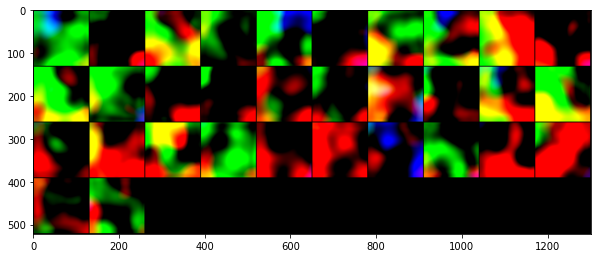

In [12]:
import torch
from torchvision.utils import save_image
from stylegan2_pytorch import ModelLoader

loader = ModelLoader(
    base_dir = './drive/MyDrive/HW6/stylegan/checkpoints',   # path to where you invoked the command line tool
    name = 'default'                   # the project name, defaults to 'default'
)

n_output = 1000
noise   = torch.randn(n_output, 512) # noise
styles  = loader.noise_to_styles(noise, trunc_psi = 0.5)  # pass through mapping network

imgs_sample = loader.styles_to_images(styles[:32])
grid_img = torchvision.utils.make_grid(imgs_sample.cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### Compress the generated images using **tar**.


In [ ]:
count = 0
os.makedirs('output', exist_ok=True)
for i in range(10):
    images = loader.styles_to_images(styles[i*100:(i+1)*100])
    for j in range(100):
        save_image(images[j], f'output/{count+1}.jpg') # save your images, or do whatever you desire
        count += 1

In [ ]:
# Compress the images.
%cd output
!tar -zcf ../images.tgz *.jpg
%cd ..

from google.colab import files
files.download("images.tgz")

/content/output
/content


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Reference**

Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW06/HW06.ipynb)

StyleGAN2 : https://github.com/lucidrains/stylegan2-pytorch